In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load the data 
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
# Make a dataframe
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Print out the dataframe
# display(test_df)

# Show the test data 
# display(train_df)

# Set how many rows are set in the dataframe
pd.set_option('display.min_rows', 10) 
pd.set_option('display.max_rows', 10) 

display(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
import re 

pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 


# train_df['Title'] = train_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
# train_df

def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
# train_df['Title']=train_df.apply(replace_titles, axis=1)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# Import the methods for pipeline processing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Function to take a dataframe and prepare it for training. It imputes (fills missing values) for"Age" and "Fare", 
# makes the "Cabin" and "Sex" column binary (i.e in a cabin or not, male or female) and one hot encodes the "Embarked" column. 
def prepare_dataframe(df, drop_columns):
    # Copying dataframe to manipulate
    new_df = df.copy(deep=True)
    
    new_df["Cabin"] = new_df["Cabin"].notnull().astype('int')
    
    binary_mapping = {"male" : 0, "female": 1}
    new_df["Sex"] = new_df["Sex"].map(binary_mapping)
    
    new_df['Title'] = new_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
    new_df['Title'] = new_df.apply(replace_titles, axis=1)
     
    numeric_features = ["Age", "Fare"]
    categorical_features = ["Embarked", "Title"]
    
    numeric_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy="mean"))])
    
    categorical_transformer = Pipeline(steps = [ ("imputer", SimpleImputer(strategy = "constant", 
                                                                           fill_value="missing")),
                                               ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features),
                                                    ("cat", categorical_transformer, categorical_features)])
    
    preprocessor.fit(new_df)
    
    transformed_data = preprocessor.transform(new_df)
    
     
    numeric_data = transformed_data[:, :len(numeric_features)]
    categorical_data = transformed_data[:, len(numeric_features):]
    
    categorical_encoded_features = preprocessor.named_transformers_['cat']['onehot'] \
                                    .get_feature_names_out(input_features=categorical_features)
    
    # Replace the columns with transformed data
    new_df[categorical_encoded_features] = categorical_data 
    new_df[numeric_features] = numeric_data
    
    # Emabarked missing removed for the training set as it has a null value 
    if "Embarked_missing" in new_df.columns:
        new_df.drop("Embarked_missing", axis=1, inplace=True)
    if "Title" in new_df.columns:
        new_df.drop("Title", axis=1, inplace=True)
    
    new_df.drop(drop_columns,axis =1, inplace=True)
    
    return pd.DataFrame(new_df)

In [5]:
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]
new_train_df = prepare_dataframe(train_df, drop_columns)
display(new_train_df)
new_train_df.columns

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,3,0,22.000000,1,0,7.2500,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,1,1,38.000000,1,0,71.2833,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,3,1,26.000000,0,0,7.9250,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,1,1,35.000000,1,0,53.1000,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,3,0,35.000000,0,0,8.0500,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0,3,0,29.699118,0,0,8.4583,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,0,1,0,54.000000,0,0,51.8625,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,0,3,0,2.000000,3,1,21.0750,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,1,3,1,27.000000,0,2,11.1333,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,1,2,1,14.000000,1,0,30.0708,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs'],
      dtype='object')

0
177
0
1


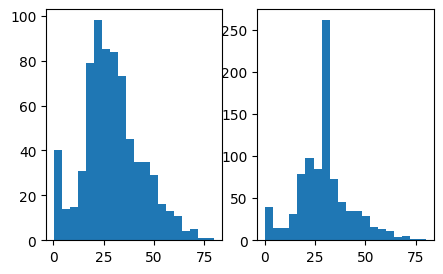

In [6]:
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

#Plotting histograms of the feature variables
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize = (5,3))

#print(len(train_df["Age"]), len(train_df_missing["Age"]))

ax[0].hist(train_df["Age"], bins=20);

ax[1].hist(new_train_df["Age"], bins=20);

print(new_train_df["Age"].isna().sum())
print(train_df["Age"].isna().sum())

print(new_test_df["Fare"].isna().sum())
print(test_df["Fare"].isna().sum())

In [7]:
# Quick fitting of the data

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

# First RandomForestClassifier 

# Setup the random seed
np.random.seed(42)

# Split up into feature variables and target variables
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = new_test_df

# Import randomforestclassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

# display(x_train)
# display(x_test)
# display(new_test_df)

RandomForestClassifier()

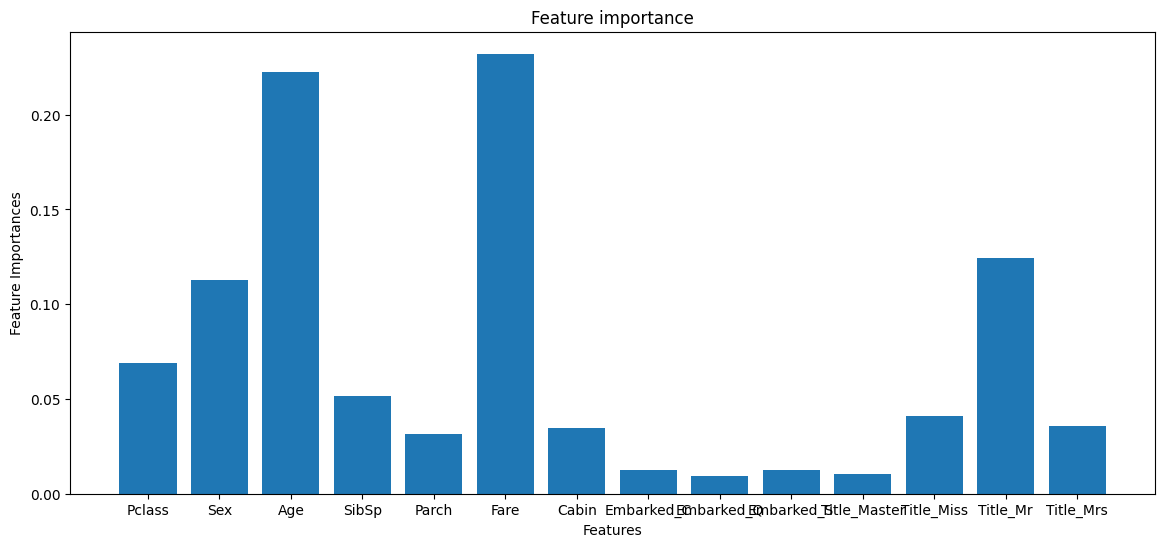

In [8]:
# Gives the importance of different features of the model
importance = clf.feature_importances_

importance_dictionary = {x_train.columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

plt.figure(figsize=(14, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [9]:
from sklearn.base import clone
np.random.seed(42)


drop_columns_cabin = ["Embarked", "Ticket", "Name", "PassengerId", "Cabin", 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs']

from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

grid = {
    'n_estimators': [10, 100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}
 

# Setup the random seed
np.random.seed(42)

x_train_cabin = prepare_dataframe(train_df, drop_columns_cabin).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_cabin = prepare_dataframe(test_df, drop_columns_cabin)

clf = RandomForestClassifier(n_jobs = 1)

rs_clf = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )

rs_clf.fit(x_train_cabin, y_train);
best_params_cabin = rs_clf.best_params_
cv_results_cabin = rs_clf.cv_results_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_spl

{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.033786,0.058573,0.132433,0.007701,2000,10,4,sqrt,None,False,"{'n_estimators': 2000, 'min_samples_split': 10...",0.810056,0.797753,0.887640,0.808989,0.848315,0.830550,0.033273,1
1,0.798482,0.009436,0.031891,0.000553,500,10,4,sqrt,None,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.798883,0.814607,0.859551,0.808989,0.848315,0.826069,0.023572,4
2,0.019309,0.000853,0.003187,0.000065,10,2,2,sqrt,20,False,"{'n_estimators': 10, 'min_samples_split': 2, '...",0.793296,0.797753,0.842697,0.792135,0.853933,0.815963,0.026719,9
3,0.732425,0.020016,0.034670,0.002649,500,2,4,sqrt,20,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.798883,0.797753,0.882022,0.808989,0.853933,0.828316,0.033807,3
4,0.161221,0.002276,0.008385,0.000118,100,10,1,sqrt,10,True,"{'n_estimators': 100, 'min_samples_split': 10,...",0.787709,0.808989,0.876404,0.797753,0.853933,0.824958,0.034260,7
5,0.818400,0.009693,0.036882,0.000992,500,2,1,sqrt,20,False,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.782123,0.775281,0.831461,0.780899,0.831461,0.800245,0.025592,10
6,0.019799,0.000540,0.003059,0.000074,10,2,2,sqrt,None,True,"{'n_estimators': 10, 'min_samples_split': 2, '...",0.793296,0.808989,0.842697,0.808989,0.853933,0.821581,0.022846,8
7,0.798399,0.006732,0.032655,0.000698,500,10,1,sqrt,10,True,"{'n_estimators': 500, 'min_samples_split': 10,...",0.798883,0.797753,0.876404,0.803371,0.853933,0.826069,0.032760,4
8,1.451274,0.008527,0.063797,0.001766,1000,5,2,sqrt,10,False,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.793296,0.803371,0.870787,0.808989,0.865169,0.828322,0.032815,2
9,3.185886,0.055022,0.116757,0.002206,2000,2,4,sqrt,20,True,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.810056,0.808989,0.853933,0.808989,0.848315,0.826056,0.020548,6


0.8228127550059632


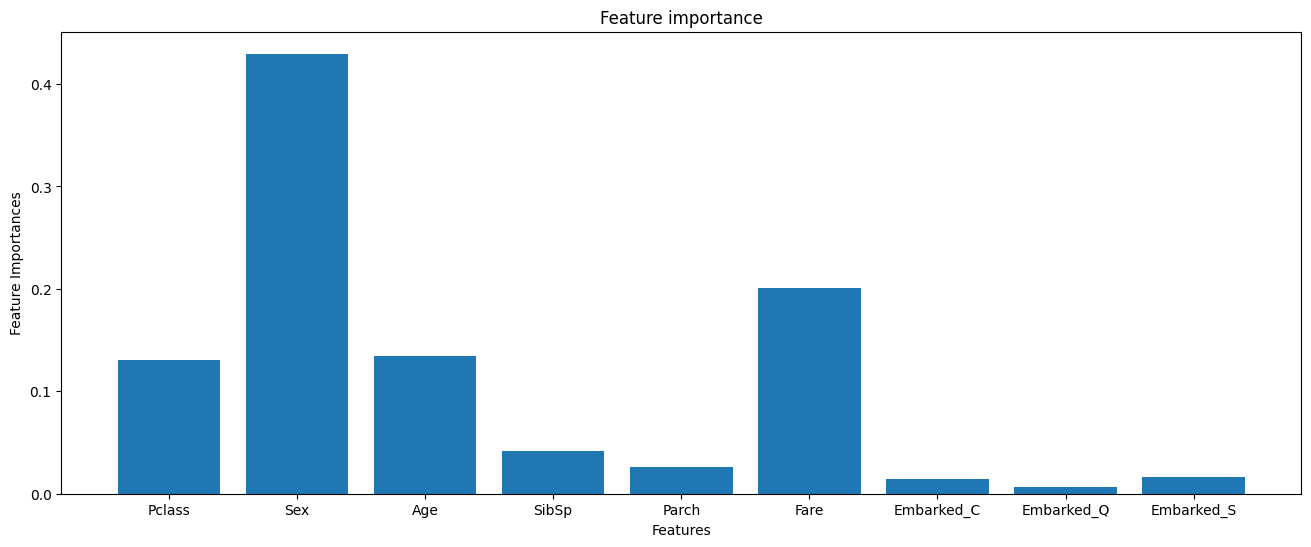

In [10]:
pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 

print(best_params_cabin)
cv_results_cabin_df = pd.DataFrame(cv_results_cabin)
display(cv_results_cabin_df)

print(cv_results_cabin_df["mean_test_score"].mean())

importance = rs_clf.best_estimator_.feature_importances_

importance_dictionary = {x_train_cabin.columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

plt.figure(figsize=(16, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

In [11]:
from sklearn.base import clone
np.random.seed(42)


drop_columns_titles = ["Embarked", "Ticket", "Name", "PassengerId", "Cabin"]

from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

grid = {
    'n_estimators': [10, 100, 500, 1000, 2000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}
 

# Setup the random seed
np.random.seed(42)

x_train_titles = prepare_dataframe(train_df, drop_columns_titles).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_titles = prepare_dataframe(test_df, drop_columns_titles)

clf = RandomForestClassifier(n_jobs = 1)

rs_clf_titles = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )

rs_clf_titles.fit(x_train_titles, y_train);
best_params_titles = rs_clf_titles.best_params_
cv_results_titles = rs_clf_titles.cv_results_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   3.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_spl

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
0.8241359613332495


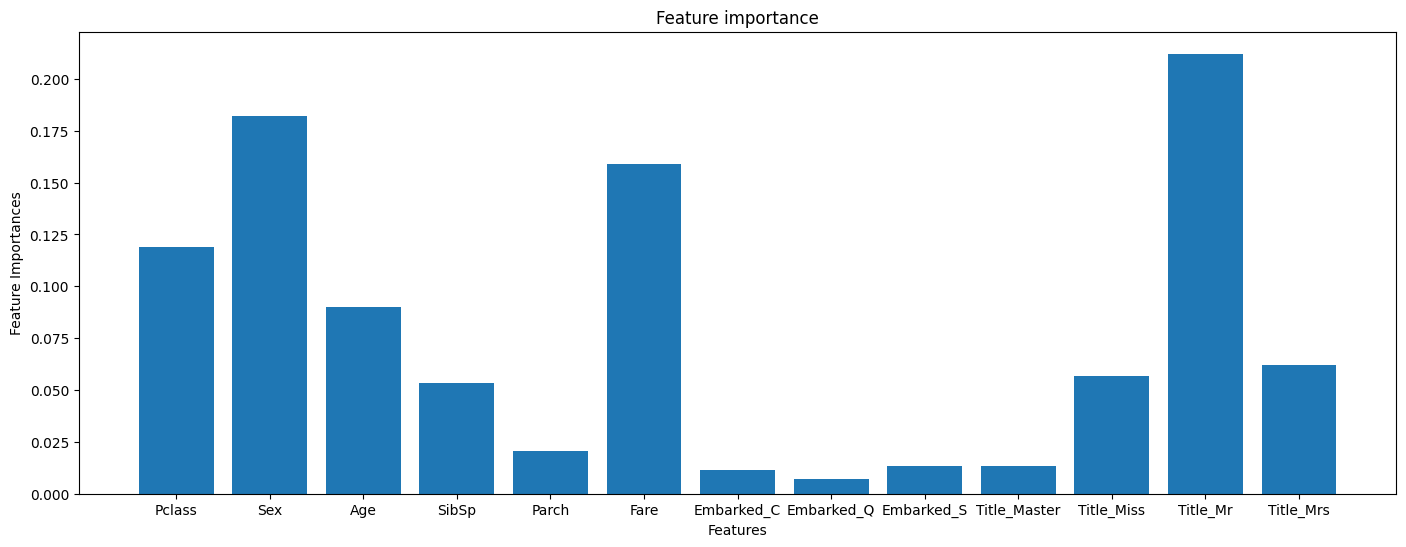

In [12]:
pd.set_option('display.min_rows', 20) 
pd.set_option('display.max_rows', 20) 

print(best_params_titles)
cv_results_titles_df = pd.DataFrame(cv_results_titles)
#display(cv_results_titles_df)

print(cv_results_titles_df["mean_test_score"].mean())

importance = rs_clf_titles.best_estimator_.feature_importances_

importance_dictionary = {x_train_titles.columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

plt.figure(figsize=(17, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()

712 891
179 179
0.8603351955307262
0.8100558659217877


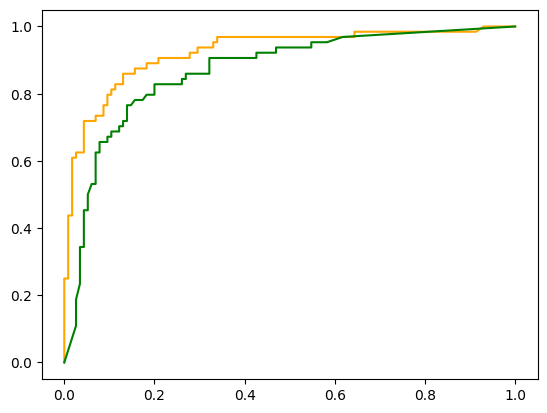

In [13]:
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve

np.random.seed(42)

# Function to divide a dataframe into validation and training sets with cross validation (k-folds). Returns the desired fold  
def cross_val_index(k_folds, x_dataframe, y_dataframe, fold_number):
    index = round(len(x_dataframe)/k_folds)
    start_index, end_index = [], []
    for i in range(k_folds):
                start_index.append(i * index)
                end_index.append((i + 1) * index if i < k_folds - 1 else len(x_dataframe))
    print(start_index[fold_number-1], end_index[fold_number-1])
    X_train = pd.concat([x_dataframe[:start_index[fold_number-1]], x_dataframe[end_index[fold_number-1]:]])
    y_train = pd.concat([y_dataframe[:start_index[fold_number-1]], y_dataframe[end_index[fold_number-1]:]])
    X_valid = x_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    y_valid = y_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    print(len(X_valid), len(y_valid))
    
    return X_train, y_train, X_valid, y_valid




drop_columns = ["Embarked", "Ticket", "Name", "PassengerId", "Cabin"]

# Setting up validation dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]


cross_val_dataframes = cross_val_index(5, x_train, y_train, 5)


best_clf = RandomForestClassifier( **{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
best_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
best_y_valid_preds = best_clf.predict(cross_val_dataframes[2])
best_y_valids_proba = best_clf.predict_proba(cross_val_dataframes[2])
best_y_valids_proba_pos = best_y_valids_proba[:, 1]
print(accuracy_score(best_y_valid_preds, cross_val_dataframes[3]))

worst_clf = RandomForestClassifier( **{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
worst_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
worst_y_valid_preds = worst_clf.predict(cross_val_dataframes[2])
worst_y_valids_proba = worst_clf.predict_proba(cross_val_dataframes[2])
worst_y_valids_proba_pos = worst_y_valids_proba[:, 1]
print(accuracy_score(worst_y_valid_preds, cross_val_dataframes[3]))

best_fpr, best_tpr, best_thresholds = roc_curve(cross_val_dataframes[3].values, best_y_valids_proba_pos)
worst_fpr, worst_tpr, worst_thresholds = roc_curve(cross_val_dataframes[3].values, worst_y_valids_proba_pos)




plt.plot(best_fpr, best_tpr, color='orange', label='ROC')
plt.plot(worst_fpr, worst_tpr, color='green', label='ROC')



In [14]:
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId", "Cabin"]

new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = prepare_dataframe(test_df, drop_columns)

best_clf = RandomForestClassifier( **{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
best_clf.fit(x_train, y_train)
best_y_preds = best_clf.predict(x_test)


output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': best_y_preds})
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
..           ...       ...
408         1300         1
409         1301         1
410         1302         1
411         1303         1
412         1304         0
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!
